# 1. Data Exploration & Cleaning

## Import dependencies, set up environment

1. `python3 -m venv .venv`
2. utilize virtual environment
    - (LINUX/MAC) `source .venv/bin/activate`
    - (WINDOWS) `.venv\Scripts\Activate.    ps1`
3. `pip install -r requirements.txt`

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import astropy as ap
import scipy as sp
import io

### Cool Seaborn Pallete

In [3]:
sns.set_palette('rocket')
sns.set_style("darkgrid")
plt.style.use("dark_background")

### Importing Data

Upon reviewing the quality of data from the "Planetary Systems" (PS) database, it was deemed better to pivot towards the "Planetary Systems Composite Data" (PSCompPars) database. In brief:
1. PS details a record for each exoplanet and each one of its references (this helps us reach original literature analyses of these bodies). Missing data is prevelant.
2. PSCompPars curates a “best available” or “most complete” set of parameters for each planet, pulling from multiple references.

So far as our exploration of exoplanets and their stars (studying the whole population of exoplanets thus far), this seems outside the scope of our analysis, and creates a cumbersome process of exploring the data. This will aid in limiting time spent cleaning the dataset, and limit our analysis to 6065 from a daunting ~32,000 records.

For an explanation on how the composite dataset aggregates all available information on exoplanet figures, please see <https://exoplanetarchive.ipac.caltech.edu/docs/pscp_calc.html>.

In [10]:
# TAP base URL (Planetary Systems Composite Data)
url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync"
# The "Planetary Systems Composite Data" database (confirmed exoplanets) is encoded as "PSCompPars" within the Exoplanet Archive
ADQL_query =    "SELECT " \
                "pl_controv_flag, pl_name, hostname, pl_letter, sy_snum, discoverymethod, disc_year," \
                "pl_radj, pl_massj, st_spectype, st_rad, st_mass, st_met, st_lum, st_teff, st_rad " \
                "FROM PSCompPars"

# Request data as CSV
params = {
    "query": ADQL_query,
    "format": "csv"
}
response = requests.get(url, params=params)

# Load into "Planetary Systems" DataFrame
pscp = pd.read_csv(io.StringIO(response.text))
print("Data loaded successfully. Number of records:", len(pscp))

Data loaded successfully. Number of records: 6065


Over 355 columns in this dataset!! All different features we can analyze in another related project pertaining to exoplanet exploration and methods for doing so . . .

After reviewing the column descriptions (as defined here: <https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html>), the following features are relevant to our exploration:
1. pl_controv_flag (is the comfirmation of this planet questioned?)
2. pl_name
3. hostname (most common star name)
4. pl_letter
5. sy_snum
6. discoverymethod
7. disc_year
8. pl_radj
9. pl_massj
10. st_spectype
11. st_rad
12. st_mass
13. st_met
14. st_lum
15. st_rad

As we will see it later, it is important to get an overview of all of the stars we have seen in the observable universe thus far, to draw a picture of what exoplanet host (stellar) date is accessable to us, vs the stars that are in the observable universe. This is done as a means to detect bias from:
1. **Educated Assumptions** Stars we choose to observe,
2. **Technical Limitations** Stars are easier to observe, and
3. **Physical Stellar Characteristics** Stars that tend to have more planets

As such, the following dataset was appended to the 

In [6]:
# TAP base URL (Kepler Stellar Table)
url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync"
# The "Kepler Stellar Table" database (confirmed exoplanets) is encoded as "keplerstellar" within the Exoplanet Archive
ADQL_query =    "SELECT " \
                "kepid, tm_designation, teff, feh, radius, mass, dens, " \
                "nconfp, nkoi, ntce " \
                "FROM keplerstellar"

# Request data as CSV
params = {
    "query": ADQL_query,
    "format": "csv"
}
response = requests.get(url, params=params)

# Load into "Kepler Stellar" DataFrame
ks = pd.read_csv(io.StringIO(response.text))
print("Data loaded successfully. Number of records:", len(ks))

Data loaded successfully. Number of records: 990244


---

## Begin Exploration of Data

### Planetary Systems - Basic Exploration

In [11]:
print('=====================================')
print('\tPLANETARY SYSTEMS DB')
print('=====================================')


print('\n~~~~~~~~~~~~~~~~~')
print('Info')
print('~~~~~~~~~~~~~~~~~')
print(pscp.info())

print('\n~~~~~~~~~~~~~~~~~')
print('Head')
print('~~~~~~~~~~~~~~~~~')
print(pscp.head())

print('\n~~~~~~~~~~~~~~~~~')
print('Description')
print('~~~~~~~~~~~~~~~~~')
print(pscp.describe())

print('\n~~~~~~~~~~~~~~~~~')
print('Missing Values')
print('~~~~~~~~~~~~~~~~~')
for col in pscp.columns:
    per_missing = pscp[col].isnull().sum() / len(pscp) * 100
    print(f'{col}: {per_missing:.2f}% missing values')

print('\n~~~~~~~~~~~~~~~~~')
print('Value Counts')
print('~~~~~~~~~~~~~~~~~')
for col in pscp:
    print(pscp[col].value_counts())

	PLANETARY SYSTEMS DB

~~~~~~~~~~~~~~~~~
Info
~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6065 entries, 0 to 6064
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pl_controv_flag  6065 non-null   int64  
 1   pl_name          6065 non-null   object 
 2   hostname         6065 non-null   object 
 3   pl_letter        6065 non-null   object 
 4   sy_snum          6065 non-null   int64  
 5   discoverymethod  6065 non-null   object 
 6   disc_year        6065 non-null   int64  
 7   pl_radj          6015 non-null   float64
 8   pl_massj         2290 non-null   float64
 9   st_spectype      2250 non-null   object 
 10  st_rad           5767 non-null   float64
 11  st_mass          6058 non-null   float64
 12  st_met           5532 non-null   float64
 13  st_lum           5773 non-null   float64
 14  st_teff          5789 non-null   float64
 15  st_rad.1         5767 non-null   float64
d

Lots of null values in the following features:
- `pl_massj` -> ~62.24% NULL
- `st_spectype` -> ~62.90% NULL

This could potentially be a consequence of survey methods? Transit observations lean heavily on visual information while radial velocity surveys are dependent on mass analysis. Lets see if there is a line of logic here to explain this discrepancy. . .

/tmp/ipykernel_291508/3007095672.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="discoverymethod", y="pl_massj_is_null", data=tempdf, palette='rocket')


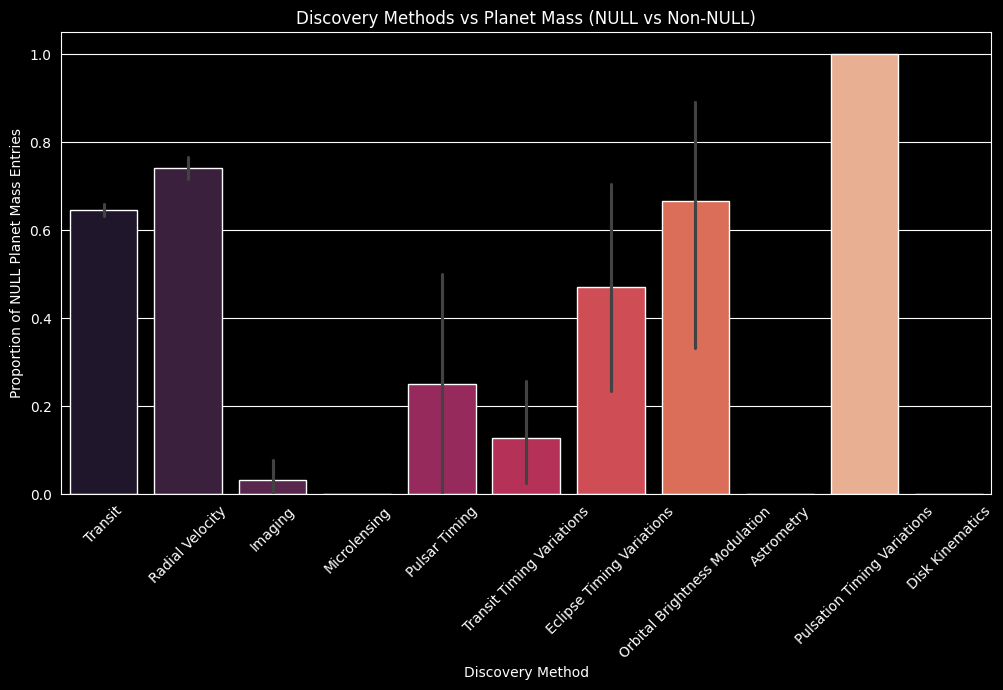

In [5]:
# bar graph of discovery methods vs pl_massj NULL and non-NULL counts
tempdf = pscp[['discoverymethod', 'pl_massj']].copy()
tempdf["pl_massj_is_null"] = tempdf["pl_massj"].isnull().astype(int)

plt.figure(figsize=(12, 6))
sns.barplot(x="discoverymethod", y="pl_massj_is_null", data=tempdf, palette='rocket')
plt.title('Discovery Methods vs Planet Mass (NULL vs Non-NULL)')
plt.xlabel('Discovery Method')
plt.ylabel('Proportion of NULL Planet Mass Entries')
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_291508/1971055209.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="discoverymethod", y="st_spectype_is_null", data=tempdf, palette='rocket')


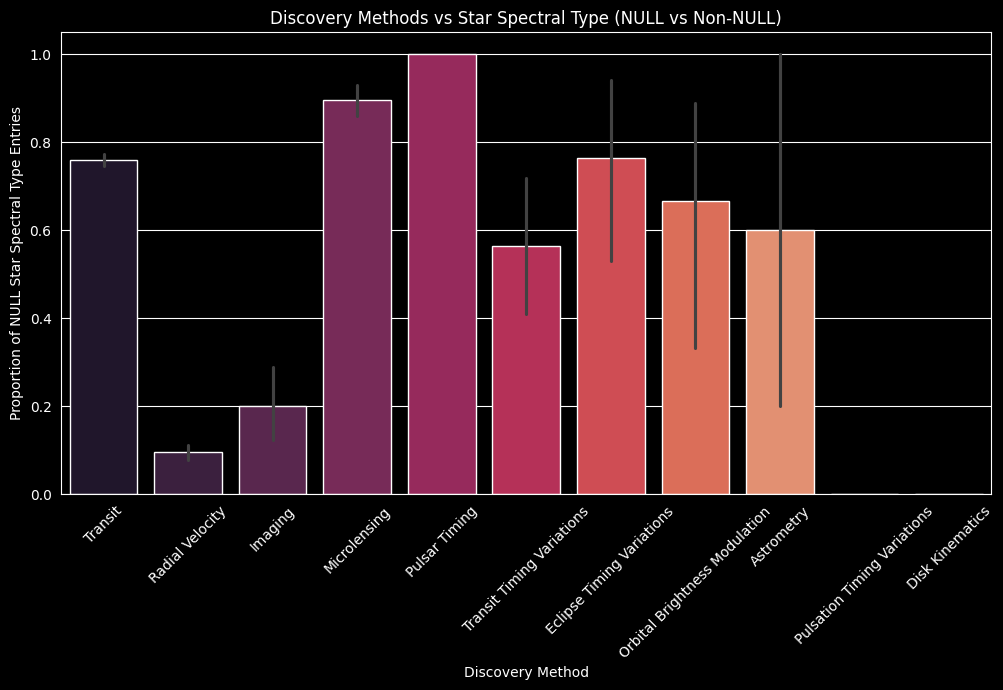

In [6]:
# bar graph of discovery methods vs st_spectype NULL and non-NULL counts
tempdf = pscp[['discoverymethod', 'st_spectype']].copy()
tempdf["st_spectype_is_null"] = tempdf["st_spectype"].isnull().astype(int)

plt.figure(figsize=(12, 6))
sns.barplot(x="discoverymethod", y="st_spectype_is_null", data=tempdf, palette='rocket')
plt.title('Discovery Methods vs Star Spectral Type (NULL vs Non-NULL)')
plt.xlabel('Discovery Method')
plt.ylabel('Proportion of NULL Star Spectral Type Entries')
plt.xticks(rotation=45)
plt.show()

Further analysis to determine how to handle the null values in the analysis . . .

In [ ]:
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('DISTRIBUTION OF DISCOVERY METHODS')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
count_disc_meth = dict(pscp['discoverymethod'].value_counts())
for method, count in count_disc_meth.items():
    print(f'{method}: {count} discoveries, {count/len(pscp)*100:.2f}%')

DISTRIBUTION OF DISCOVERY METHODS
Transit: 4474 discoveries, 73.77%
Radial Velocity: 1158 discoveries, 19.09%
Microlensing: 262 discoveries, 4.32%
Imaging: 90 discoveries, 1.48%
Transit Timing Variations: 39 discoveries, 0.64%
Eclipse Timing Variations: 17 discoveries, 0.28%
Orbital Brightness Modulation: 9 discoveries, 0.15%
Pulsar Timing: 8 discoveries, 0.13%
Astrometry: 5 discoveries, 0.08%
Pulsation Timing Variations: 2 discoveries, 0.03%
Disk Kinematics: 1 discoveries, 0.02%


### Kepler Star Target Observations

In [12]:
print('=====================================')
print('\KEPLER STELLAR DB')
print('=====================================')


print('\n~~~~~~~~~~~~~~~~~')
print('Info')
print('~~~~~~~~~~~~~~~~~')
print(ks.info())

print('\n~~~~~~~~~~~~~~~~~')
print('Head')
print('~~~~~~~~~~~~~~~~~')
print(ks.head())

print('\n~~~~~~~~~~~~~~~~~')
print('Description')
print('~~~~~~~~~~~~~~~~~')
print(ks.describe())

print('\n~~~~~~~~~~~~~~~~~')
print('Missing Values')
print('~~~~~~~~~~~~~~~~~')
for col in ks.columns:
    per_missing = ks[col].isnull().sum() / len(ks) * 100
    print(f'{col}: {per_missing:.2f}% missing values')

print('\n~~~~~~~~~~~~~~~~~')
print('Value Counts')
print('~~~~~~~~~~~~~~~~~')
for col in ks:
    print(ks[col].value_counts())

<>:2: SyntaxWarning: invalid escape sequence '\K'
<>:2: SyntaxWarning: invalid escape sequence '\K'
/tmp/ipykernel_8440/1386476828.py:2: SyntaxWarning: invalid escape sequence '\K'
  print('\KEPLER STELLAR DB')


\KEPLER STELLAR DB

~~~~~~~~~~~~~~~~~
Info
~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990244 entries, 0 to 990243
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   kepid           990244 non-null  int64  
 1   tm_designation  988042 non-null  object 
 2   teff            990244 non-null  int64  
 3   feh             990244 non-null  float64
 4   radius          990244 non-null  float64
 5   mass            787129 non-null  float64
 6   dens            787129 non-null  float64
 7   nconfp          990244 non-null  int64  
 8   nkoi            990244 non-null  int64  
 9   ntce            990244 non-null  int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 75.5+ MB
None

~~~~~~~~~~~~~~~~~
Head
~~~~~~~~~~~~~~~~~
      kepid           tm_designation  teff  feh  radius  mass  dens  nconfp  \
0  10002413  2MASS J19103477+4657082  5708 -0.2   0.956   NaN   NaN       0   
1  10002

A lot of dupplicates observed from the Kepler Stellar dataset (see 'Value Counts', above), however something that is troubling is that this particular dataset does not detail the stellar classification of each of the stars, unfortunately, a key aspect to the analysis I plan on performing. I may, again, need to rely upon approximate-classificaitons based on temperature, for the KR star classificaiton system.

In [ ]:
ks = ks.drop_duplicates()

print("Duplicates removed. Number of records after deduplication:", len(ks))
print('\n~~~~~~~~~~~~~~~~~')
print('Value Counts')
print('~~~~~~~~~~~~~~~~~')
for col in ks:
    print(ks[col].value_counts())

Duplicates removed. Number of records after deduplication: 677750

~~~~~~~~~~~~~~~~~
Value Counts
~~~~~~~~~~~~~~~~~
kepid
4169315    5
6966132    5
6965782    5
6965789    5
9953851    5
          ..
8235024    1
8299231    1
8296111    1
8301649    1
8547781    1
Name: count, Length: 200038, dtype: int64
tm_designation
2MASS J19281409+4355308    5
2MASS J19512531+4937587    5
2MASS J19512874+4936598    5
2MASS J19150907+4938233    5
2MASS J19561019+4358201    5
                          ..
2MASS J19290748+4049156    1
2MASS J19562168+4056217    1
2MASS J19513319+4049095    1
2MASS J19402911+4109069    1
2MASS J19320828+4108090    1
Name: count, Length: 199469, dtype: int64
teff
5780     15473
6343      2260
6063      1545
6108      1462
6167      1340
         ...  
9347         1
3240         1
8716         1
10594        1
7929         1
Name: count, Length: 6493, dtype: int64
feh
-0.200    173237
 0.070     32907
 0.000     26969
-0.100     23037
-0.120     19695
           ...  
-

Just by reviewing the 'kepid' feature, further data cleaning is required to remove duplicate entries and ensure that we are working with a clean dataset.

In [15]:
print(ks[ks['kepid'] == 9995748])

          kepid           tm_designation  teff  feh  radius    mass   dens  \
194432  9995748  2MASS J18550787+4659221  6211 -0.2   1.027     NaN    NaN   
218932  9995748  2MASS J18550787+4659221  6205 -0.2   0.997  1.0527  1.498   
566381  9995748  2MASS J18550787+4659221  6205 -0.2   0.997  1.0530  1.498   
792459  9995748  2MASS J18550787+4659221  6214 -0.2   1.003  1.0490  1.462   

        nconfp  nkoi  ntce  
194432       0     0     0  
218932       0     0     0  
566381       0     0     0  
792459       0     0     0  


### Exoplanets and Their Stars

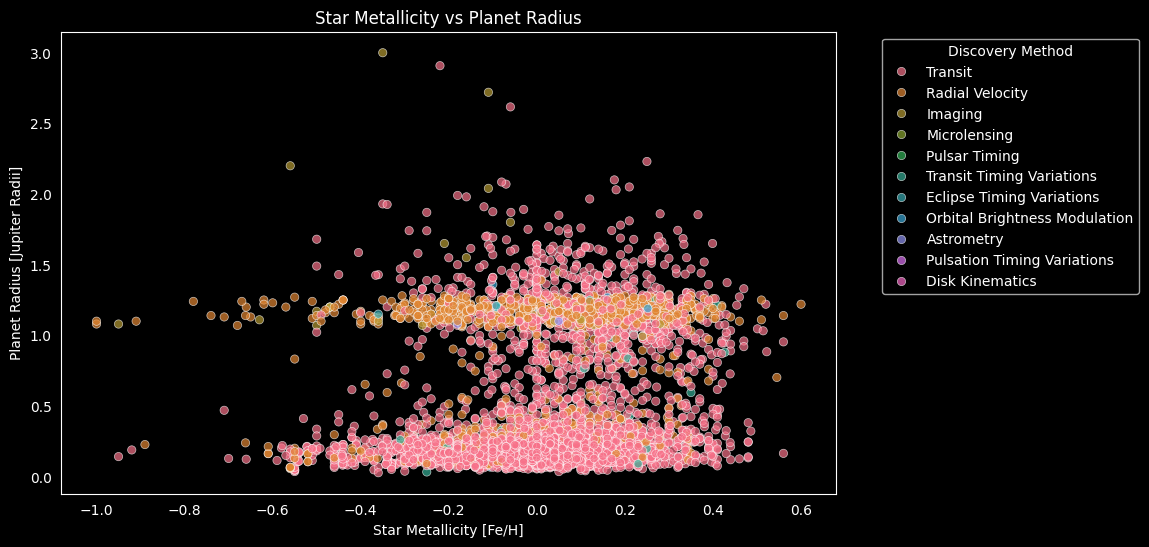

In [8]:
# this anxample analysis of star metallicity vs planet radius
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pscp, x='st_met', y='pl_radj', hue='discoverymethod', alpha=0.7)
plt.title('Star Metallicity vs Planet Radius')
plt.xlabel('Star Metallicity [Fe/H]')
plt.ylabel('Planet Radius [Jupiter Radii]')
plt.legend(title='Discovery Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

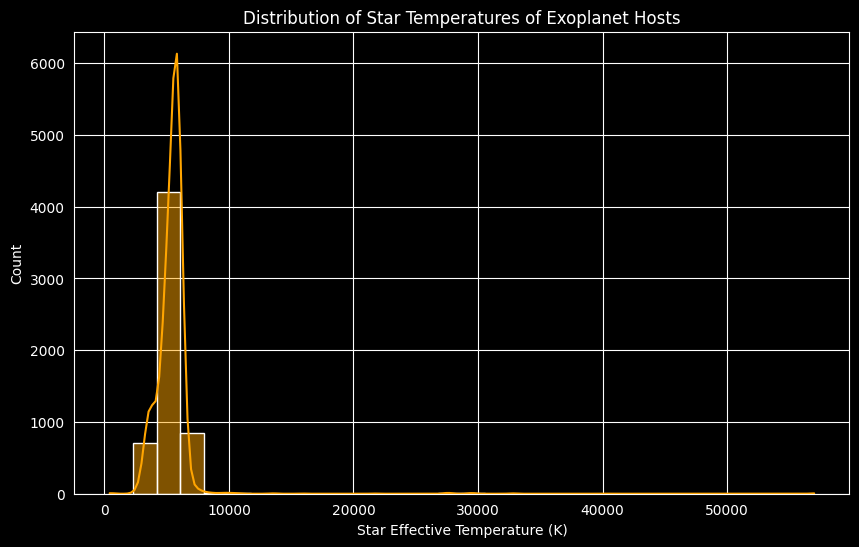

count     5789.000000
mean      5407.651226
std       1751.497979
min        415.000000
25%       4914.000000
50%       5551.000000
75%       5901.000000
max      57000.000000
Name: st_teff, dtype: float64


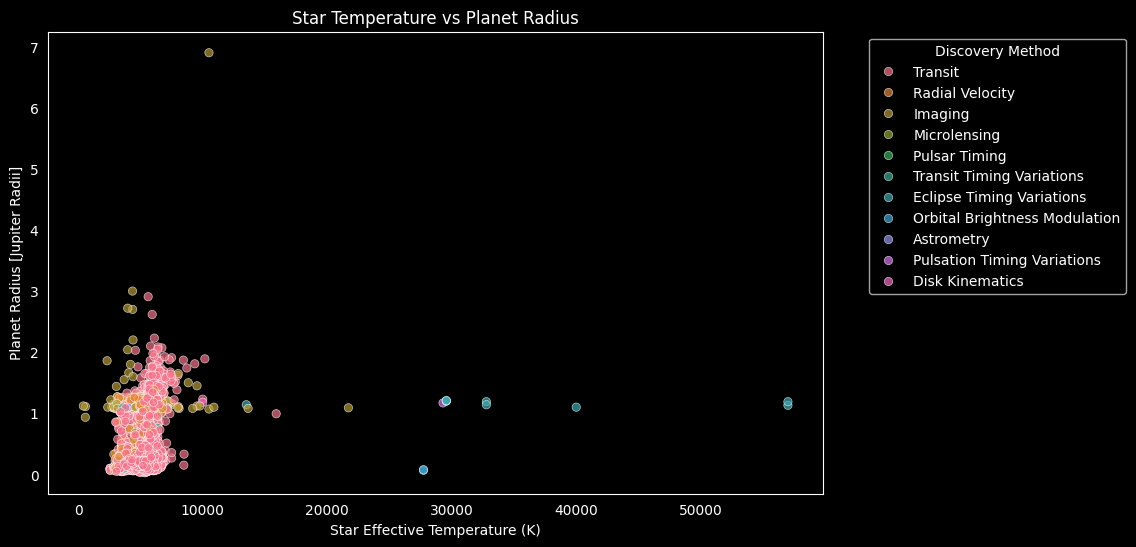

In [9]:
# Star temperature distribution over OBSERVED exoplanets
plt.figure(figsize=(10, 6))
sns.histplot(pscp['st_teff'].dropna(), bins=30, kde=True, color='orange')
plt.title('Distribution of Star Temperatures of Exoplanet Hosts')
plt.xlabel('Star Effective Temperature (K)')
plt.ylabel('Count')

plt.show()

print(pscp["st_teff"].describe())

# Exoplanets vs star temperature
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pscp, x='st_teff', y='pl_radj', hue='discoverymethod', alpha=0.7)
plt.title('Star Temperature vs Planet Radius')
plt.xlabel('Star Effective Temperature (K)')
plt.ylabel('Planet Radius [Jupiter Radii]')
plt.legend(title='Discovery Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

In [10]:
# Scatterplot of star size vs 

In [11]:
# Exoplanets vs star metallicity

## Data Cleaning

### Define missing spectral types
As seen above, most stars are not defined by a sepctral type (in fact, this is the case for 62.90% of exoplanet host stars observed). Without this information, it would be impossible to define how certain observation types favor one type of star over another.

Star classifications, however, can be defined by primarily by temperature (something that is available to us in this analysis). The Morgan-Keenan classification system (the standard for clasiffying stars) is defined as follows:
- O: > 30,000 K
- B: 10,000–30,000 K
- A: 7,500–10,000 K
- F: 6,000–7,500 K
- G: 5,200–6,000 K (the Sun is G2V)
- K: 3,900–5,200 K
- M: < 3,900 K

with subclasses (as indicated by a number 0-9) identifying different steps within a major classification.

Additionally, the lumonocity class is defined as follows:
- I = supergiants
- II = bright giants
- III = giants
- IV = subgiants
- V = main sequence

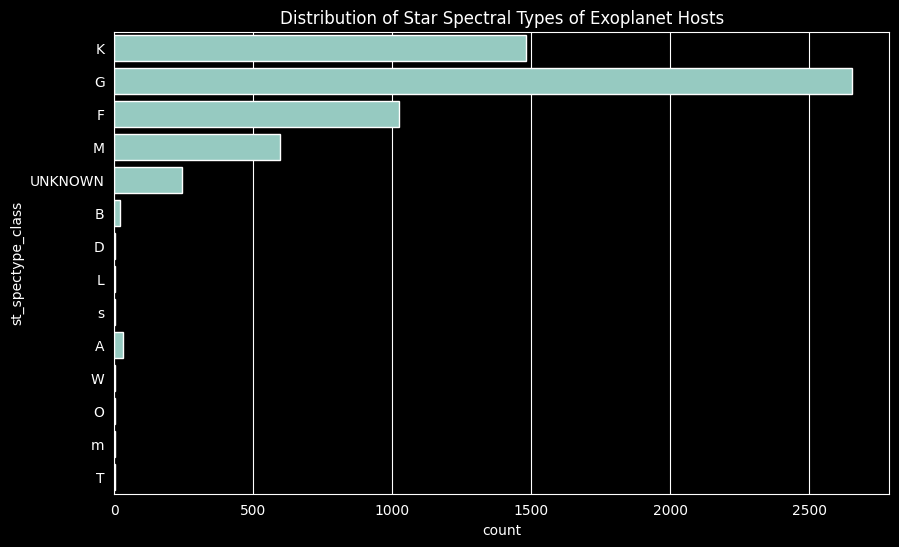

In [ ]:
# Create new feature for first character of st_spectype
pscp['st_spectype_class'] = pscp['st_spectype'].astype(str).str[0]

# Method for defining specteral type based on star temperature ranges
def fix_spectype(row):
    # spectype already . . .
    if not pd.isnull(row["st_spectype"]):
        return row["st_spectype"][0]
    # else, assign based on temperatures. . .
    elif pd.isnull(row["st_spectype"]) and row['st_teff'] > 30000:
        return "O"
    elif pd.isnull(row["st_spectype"]) and 10000 < row['st_teff'] <= 30000:
        return "B"
    elif pd.isnull(row["st_spectype"]) and 7500 < row['st_teff'] <= 10000:
        return "A"
    elif pd.isnull(row["st_spectype"]) and 6000 < row['st_teff'] <= 7500:
        return "F"
    elif pd.isnull(row["st_spectype"]) and 5200 < row['st_teff'] <= 6000:
        return "G"
    elif pd.isnull(row["st_spectype"]) and 3700 < row['st_teff'] <= 5200:
        return "K"
    elif pd.isnull(row["st_spectype"]) and row['st_teff'] <= 3700:
        return "M"
    # if no temp value and no spectype . . . 
    else:
        return "UNKNOWN"

pscp["st_spectype_class"] = pscp.apply(fix_spectype, axis=1)

# Output results before defining spectype for null values (that can be classified)
plt.figure(figsize=(10,6))
sns.countplot(data=pscp['st_spectype_class'], alpha=0.7)
plt.title('Distribution of Star Spectral Types of Exoplanet Hosts')
plt.show()


Verified that stars have been classified accordingly, now dropping the values (~4% of dataset) that cannot be utilized for my analysis based off of specular classification as well as by temperature alone. This is statistically insignifigant.

In [147]:
# Drop insignifigant rows
pscp = pscp[pscp['st_spectype_class'] != "UNKNOWN"]

# Verify
total_records = len(pscp)
c_n_star_temp_and_type = pscp["st_spectype_class"].value_counts().get("UNKNOWN", 0) # had to fix this to get a safe return (should be 0)
print(f'{(c_n_star_temp_and_type / total_records) * 100}% of dataset contains host stars that cannot be classified.')

0.0% of dataset contains host stars that cannot be classified.


## Analyze

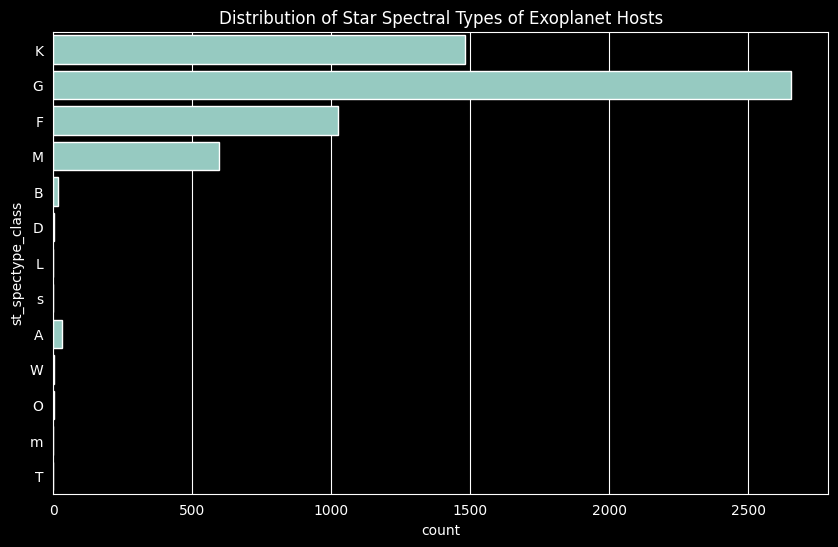

In [ ]:
# Output results after defining spectype for null values (that can be classified)
plt.figure(figsize=(10,6))
sns.countplot(data=pscp['st_spectype_class'], alpha=0.7)
plt.title('Distribution of Star Spectral Types of Exoplanet Hosts')
plt.show()

As compared to what I would expect from these analyses, there is a bias in exoplanet hosts toward G-type stars (those most similiar to the Sun). This could be in part due to the Kepler space-telescope's mission of finding exoplanets which were presumed to be found primarily around Sun-like stars. Stars studied most deeply typically have the following features:
1. Bright
2. Nearby
3. Sun-like
4. Spectroscopically well‑characterized

The consequence of this is that M-type (the most common star type) are not represented as much as I would figure they would be, given how common they are. What has yet to be considered, however, is whether the distribution of stars found to host exoplanets is a consequence of which of these factors:
1. Observational methods favoring star types
2. Exoplanets typically forming around these star types
3. 